# Analysis of eulerian field of the NWES

In [3]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
import plotly.express as px # for 3d plotting
from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in k
deg2rad = np.pi / 180.

# for fieldsets
field_directory = ('/storage/shared/oceanparcels/input_data/CMEMS/'
                   'NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013/')
input_filename_field_nologin = ('CMEMS_v6r1_NWS_PHY_NRT_NL_01hav3D_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                '{year_t:04d}{month_t:02d}{day_t:02d}_'
                                'R{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}_HC01.nc')

input_filename_metoffice = ('metoffice_foam1_amm15_NWS_CUR_'
                            'b{year_t:04d}{month_tr:02d}{day_t:02d}_'
                            'hi{year_tplus:04d}{month_tplus:02d}{day_tplus:02d}.nc')



colorlist=np.array(['c','purple','orange','navy','red','black','green'])

In [5]:
# general settings
B = 0.68
tau = 2759.97
runtime =  timedelta(days=30)# timedelta(days=10)
starttimes=np.array([datetime(2023, 9, 1, 0, 0, 0, 0),
                      datetime(2023, 10, 1, 0, 0, 0, 0),
                      datetime(2023, 11, 1, 0, 0, 0, 0),
                      datetime(2023, 12, 1, 0, 0, 0, 0),
                      datetime(2024, 1, 1, 0, 0, 0, 0),
                      datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)



## Eulerian analysis fieldsets
Below we investigate the Eulerian properties of the velocity fieldset used. That is:
- magnitude of spacial and temporal gradients in the velocity
- typical correlation length velocity  

With these values we can estimate if we expect an effect from Inertia or not

### Calculate and plot material derivatives fields
We import the fieldsets 1 month at a time (as is used in the simulations).  
Before 1/9/2023 we import the data from metuoffice uk, after 1/9/2023 we   
import data from nologin Spain.

In [6]:
# import data
starttime = starttimes[2]
print(starttime)

endtime = starttime + runtime
dt_field = timedelta(days=1)

if (starttime < date_new):
    input_filename =  input_filename_metoffice
    dt_name_field = timedelta(days=2)
else: 
    input_filename = input_filename_field_nologin
    dt_name_field = timedelta(days=1)

oceanfiles = create_filelist(field_directory, input_filename,
                               starttime, endtime, dt_field, dt_name_field)

dflow = xr.open_mfdataset(oceanfiles, drop_variables = ['thetao','so','depth'])
# only keep upper layer
dflow['uo'] = dflow['uo'][:,0,:,:]
dflow['vo'] = dflow['vo'][:,0,:,:]
dlon = (dflow['longitude'][1]-dflow['longitude'][0]).values
dlat = (dflow['latitude'][1]-dflow['latitude'][0]).values
dtime = (dflow['time'][1]-dflow['time'][0]).values

time, lon, lat = (dflow['time'].values, dflow['longitude'].values,dflow['latitude'].values)
LON, LAT = np.meshgrid(lon,lat)
LON_dx, LAT_dx = np.meshgrid(lon[0:-1]+0.5*dlon,lat)
LON_dy, LAT_dy = np.meshgrid(lon,lat[0:-1]+0.5*dlat)
# dflow=dflow.fillna(value={"uo":0,"vo":0})


2023-11-01 00:00:00


In [7]:
# use xarray diff function to calculate derivatives 
# define jacobean 
Jtime = 1/3600 # seconds per hour
Jx = 1 / (2 * Rearth * np.arcsin(np.sqrt(0.5 * ( np.cos(LAT[:,1:] * deg2rad)**2) * (1 - np.cos(dlon * deg2rad)))))
Jy = 1 / (Rearth * dlat * deg2rad)

# dimensions (time, lat, lon)
dvdt = dflow['vo'].diff(dim='time',n=1,label="upper") * Jtime
dvdx = dflow['vo'].diff(dim='longitude',n=1,label="upper") * Jx
dvdy = dflow['vo'].diff(dim='latitude',n=1,label="upper") * Jy

dudt = dflow['uo'].diff(dim='time',n=1,label="upper") * Jtime
dudx = dflow['uo'].diff(dim='longitude',n=1,label="upper") * Jx
dudy = dflow['uo'].diff(dim='latitude',n=1,label="upper") * Jy


# 
dvdx['longitude']=dvdx['longitude']-0.5*dlon
dudx['longitude']=dudx['longitude']-0.5*dlon
dvdy['latitude']=dvdy['latitude']-0.5*dlat
dvdy['latitude']=dvdy['latitude']-0.5*dlat
dvdt['time']=dvdt['time']-0.5*dtime
dudt['time']=dudt['time']-0.5*dtime

In [8]:
# calculate u and v component material derivative field
dvdx_agrid=dvdx.interp(longitude=lon[1:-1])[1:-1,1:-1,:]
dudx_agrid=dudx.interp(longitude=lon[1:-1])[1:-1,1:-1,:]
dvdy_agrid=dvdy.interp(latitude=lat[1:-1])[1:-1,:,1:-1]
dudy_agrid=dudy.interp(latitude=lat[1:-1])[1:-1,:,1:-1]
dvdt_agrid = dvdt.interp(time=time[1:-1])[:,1:-1,1:-1]
dudt_agrid = dudt.interp(time=time[1:-1])[:,1:-1,1:-1]
u = dflow['uo'][1:-1,1:-1,1:-1]
v = dflow['vo'][1:-1,1:-1,1:-1]
DuDt = (dudt_agrid + u * dudx_agrid + v * dudy_agrid).load()
DvDt = (dvdt_agrid + u * dvdx_agrid + v * dvdy_agrid).load()
vorticity = (dvdx_agrid-dudy_agrid)
print(vorticity)

<xarray.DataArray (time: 742, latitude: 549, longitude: 934)> Size: 3GB
dask.array<sub, shape=(742, 549, 934), dtype=float64, chunksize=(1, 549, 934), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 6kB 2023-11-01T01:30:00 ... 2023-12-01T2...
  * latitude   (latitude) float32 2kB 46.03 46.06 46.09 ... 61.2 61.23 61.25
  * longitude  (longitude) float32 4kB -15.97 -15.94 -15.91 ... 9.921 9.949


#### Plotting fields

In [ ]:
# plot components velocity fields next to eachother to compare:
# options
day_averaged = False
plot_time = 10.5 # in days 
naxes = 2
fig, axs = plt.subplots(1,naxes,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
tindex=int(plot_time*24)
if(day_averaged == True):
    pcm0 = axs[0].pcolormesh(LON, LAT ,dflow['uo'][tindex:tindex+24].mean(dim='time').values,cmap='RdBu', vmin=-1,vmax=1)
    pcm1 = axs[1].pcolormesh(LON, LAT ,dflow['vo'][tindex:tindex+24].mean(dim='time').values,cmap='RdBu', vmin=-1,vmax=1)
    
else:
    pcm0 = axs[0].pcolormesh(LON, LAT ,dflow['uo'][tindex].values,cmap='RdBu', vmin=-1,vmax=1)
    pcm1 = axs[1].pcolormesh(LON, LAT ,dflow['vo'][tindex].values,cmap='RdBu', vmin=-1,vmax=1)
date = dflow['time'][tindex].values
cxbar=fig.colorbar(pcm0,label='dv/dx [(m/s)/km]',fraction=0.03)
cxbar=fig.colorbar(pcm1,label='dv/dy [(m/s)/km]',fraction=0.03)
for a in range(0,naxes,1):
    axs[a].coastlines()  
    axs[a].set_xlabel('longitude [$^{\\circ}$]')
    axs[a].set_ylabel('latitude [$^{\\circ}$]')
    gl = axs[a].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
    # axs[a].set_ylim(50,60)

date = dflow['time'][tindex].values
if(day_averaged==True):
    fig.suptitle(f'daily average {np.datetime64(date,'D')}', fontsize=30) #options, Y, M, D, h, m, s for np.datetime
else:
    fig.suptitle(f'{np.datetime64(date,'m')}', fontsize=30)




In [ ]:
# plot material derivative

day_averaged = False
plot_time = 10.5 # in days 
naxes = 2
fig, axs = plt.subplots(1,naxes,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
tindex=int(plot_time*24)
if(day_averaged == True):
    pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DuDt[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)
    pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt[tindex:tindex+24].mean(dim='time').values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)

    
else:
    pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DuDt[tindex].values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)
    pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt[tindex].values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)
date = dflow['time'][tindex].values
cxbar=fig.colorbar(pcm0,label='Du/Dt [m/s$^2$]', fraction = 0.03)
cxbar=fig.colorbar(pcm1,label='Dv/Dt [m/s$^2$]',fraction=0.03)
for a in range(0,naxes,1):
    axs[a].coastlines()  
    axs[a].set_xlabel('longitude [$^{\\circ}$]')
    axs[a].set_ylabel('latitude [$^{\\circ}$]')
    gl = axs[a].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
    # axs[a].set_ylim(50,60)

date = dflow['time'][tindex].values
if(day_averaged==True):
    fig.suptitle(f'daily average {np.datetime64(date,'D')}', fontsize=30) #options, Y, M, D, h, m, s for np.datetime
else:
    fig.suptitle(f'{np.datetime64(date,'m')}', fontsize=30)

fig.tight_layout()



In [ ]:
# plot daily averaged vorticity field
# DuDtspeed = np.sqrt(DuDt**2+DvDt**2)
# set field
field = DuDt
name = 'DuDt'
vmin = -0.0002
vmax = 0.0002
day_averaged = True
if(day_averaged == True):
    Tmax = 30 #days
else:
    Tmax = 720 #hours 
for tindex in range(0,Tmax,1):
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    # pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , vorticity[tindex*24:(tindex+1)*24].mean(dim='time'),cmap='RdBu',vmin=-0.0002,vmax=0.0002)
    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1] , DvDt[tindex*24:(tindex+1)*24].mean(dim='time'),cmap='RdBu',vmin=-0.00005,vmax=0.00005)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    # cxbar=fig.colorbar(pcm,label='$\\omega $ [1/s]',fraction=0.03)
    cxbar=fig.colorbar(pcm,label='Dv/Dt [m/s$^2$]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    fig.tight_layout()
    # fig.savefig(f'../figures/eulerian_field/frames/november/vorticity/vorticity_day_averaged{tindex:04d}.png')
    fig.savefig(f'../figures/eulerian_field/frames/november/material_derivative/DvDt_day_averaged{tindex:04d}.png')
    plt.close(fig)

    # to make movie: ffmpeg -framerate 2 -i vorticity_day_averaged%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 vorticity_day_averaged.mp4
    # ffmpeg -framerate 2 -i DuDt_day_averaged%04d.png  -vcodec libx264 -pix_fmt yuv420p -r 10 DuDt_day_averaged.mp4



In [ ]:
# plot size vector material derivative
for tindex in range(0,24*2,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   

    pcm = ax.pcolormesh(LON, LAT, dflow['uo'][tindex].values,cmap='RdBu',vmin=-1.5,vmax=1.5)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label='u [m/s]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex]}', fontsize=20)
    ax.set_xlim(-3,9.5)
    ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/november/velocity/u_field_hourly{tindex:04d}.png')
    plt.close(fig)


In [ ]:
# plot u field (averaged over 1 day (=2 tidal cycles))
for tindex in range(0,30,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   
    # dflow['uo'][tindex*24:(tindex+1)*24].mean(dim='time').values

    pcm = ax.pcolormesh(LON, LAT, dflow['vo'][tindex*24:(tindex+1)*24].mean(dim='time').values,cmap='RdBu',vmin=-1.5,vmax=1.5)

    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label='v [m/s]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/november/velocity/v_field_day_avaraged{tindex:04d}.png')
    plt.close(fig)


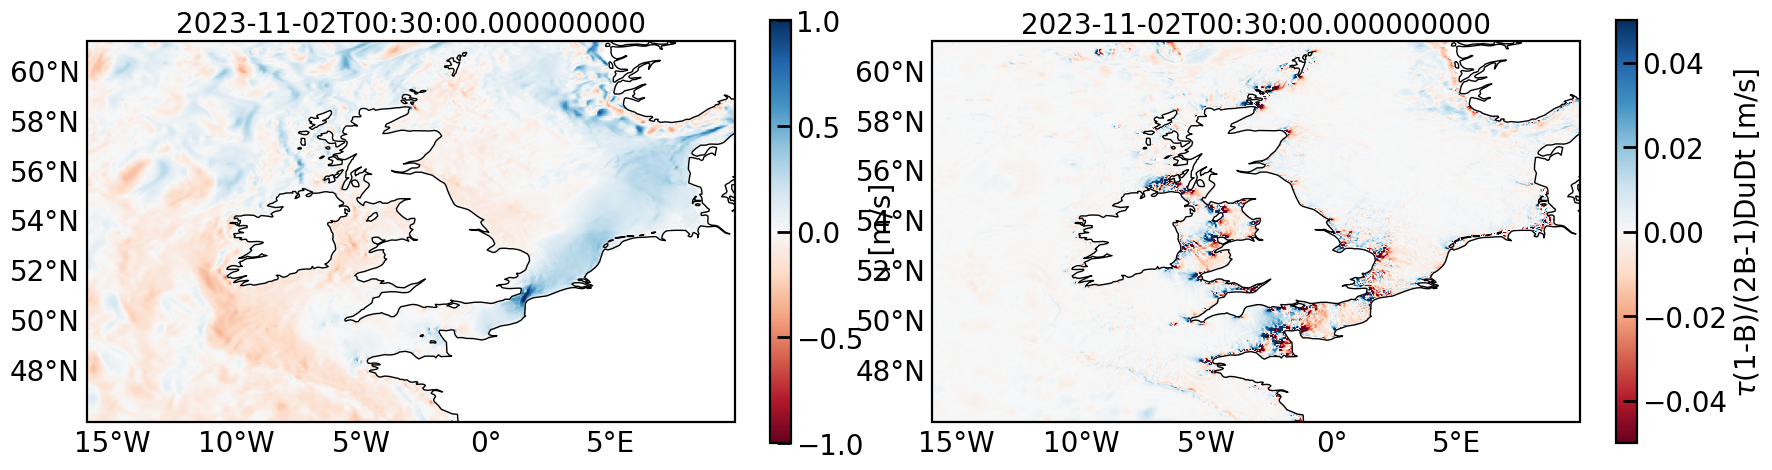

In [17]:
# plot uf+tau * (1-B)/(2B+1)DuDt
# field = dflow['vo'][1:-1,1:-1]+tau*(1-B)/(2*B-1)*DvDt
# plot u field (averaged over 1 day (=2 tidal cycles))
# for tindex in range(0,30,1):#range(0,24*30-2,1):

tindex=1
fig, axs = plt.subplots(1,2,figsize=(20,10),subplot_kw={'projection':ccrs.PlateCarree()})


# dflow['uo'][tindex*24:(tindex+1)*24].mean(dim='time').values

pcm0= axs[0].pcolormesh(LON, LAT, dflow['vo'][tindex*24:(tindex+1)*24].mean(dim='time').values,cmap='RdBu',vmin=-1,vmax=1)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], +tau*(1-B)/(2*B-1)*DuDt.mean(dim='time').values,cmap='RdBu',vmin=-0.05,vmax=0.05)
cxbar=fig.colorbar(pcm0,label='u [m/s]',fraction=0.03)
cxbar=fig.colorbar(pcm1,label='$\\tau$(1-B)/(2B-1)DuDt [m/s]',fraction=0.03)
for ax in axs:
    ax.coastlines()  
    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    # ax.set_xlim(-3,9.5)
    # ax.set_ylim(51,61)
    # fig.savefig(rf'../figures/eulerian_field/frames/november/velocity/u_field_day_avaraged{tindex:04d}.png')
    # plt.close(fig)



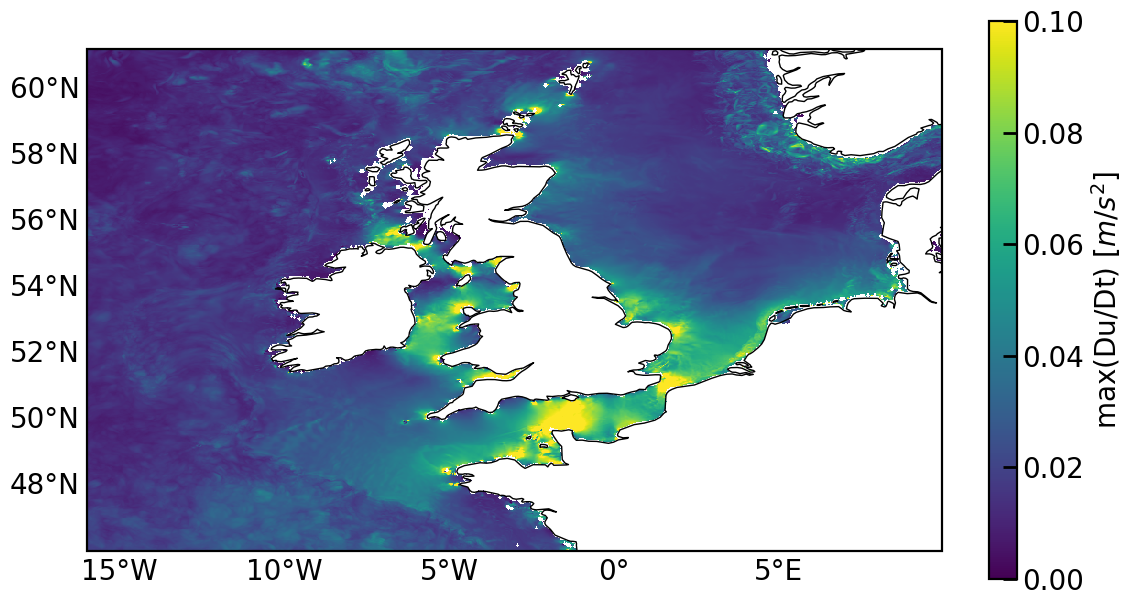

In [11]:
# plot maximum material 


fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()   

pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], tau*(1-B)/(2*B+1)*np.max(np.sqrt((DuDt)**2+(DvDt)**2).values, axis = 0), cmap='viridis',vmin=0,vmax=0.1)

ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')

cxbar=fig.colorbar(pcm,label='max(Du/Dt) [$m/s^2$]', fraction=0.03)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}



# ax.set_xlim(-3,9.5)
# ax.set_ylim(50,60)
   



In [ ]:
# plot u field (averaged over 1 day (=2 tidal cycles))
for tindex in range(0,30,1):#range(0,24*30-2,1):

    fig, ax = plt.subplots(figsize=(12,10),subplot_kw={'projection':ccrs.PlateCarree()})
    ax.coastlines()   
    # dflow['uo'][tindex*24:(tindex+1)*24].mean(dim='time').values

    pcm = ax.pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt[tindex*24:(tindex+1)*24].mean(dim='time').values,cmap='RdBu',vmin=-0.00005,vmax=0.00005)


    ax.set_xlabel('longitude [$^{\\circ}$]')
    ax.set_ylabel('latitude [$^{\\circ}$]')

    cxbar=fig.colorbar(pcm,label='Du/Dt [m/s$^2$]',fraction=0.03)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style =  {'size': 20}


    ax.set_title(f'{time[tindex*24]}', fontsize=20)
    ax.set_xlim(-3,9.5)
    ax.set_ylim(51,61)
    fig.savefig(f'../figures/eulerian_field/frames/november/velocity/DvDt_field_day_avaraged{tindex:04d}.png')
    plt.close(fig)


In [ ]:
# plotmax absolute material derivative comonents
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.max(np.fabs(DuDt).values,axis=0),cmap='viridis',vmin=0,vmax=0.00025)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], np.max(np.fabs(DvDt).values,axis=0),cmap='viridis',vmin=0,vmax=0.00025)
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$ max(|du/dt|)  $ [$m/s^2$]')
cxbar=fig.colorbar(pcm1,label='$ max(dv/dt) \\rangle $ [$m/s^2$]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)

In [ ]:
# calculate mean absolute value velocities and mean absolute value material derivative
DuDt_abs_mean=np.sqrt((DuDt**2)).mean(dim='time').load()
DvDt_abs_mean=np.sqrt((DvDt**2)).mean(dim='time').load()
u_abs_mean=np.sqrt((u**2)).mean(dim='time').load()
v_abs_mean=np.sqrt((v**2)).mean(dim='time').load()


In [ ]:
# plot mean absolute value material derivative
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DuDt_abs_mean.values,cmap='viridis',vmin=0,vmax=0.1*10**(-3))
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], DvDt_abs_mean.values,cmap='viridis',vmin=0,vmax=0.1*10**(-3))
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$ \\langle |du/dt| \\rangle $ [$m/s^2$]')
cxbar=fig.colorbar(pcm1,label='$ \\langle |dv/dt| \\rangle $ [$m/s^2$]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)

In [ ]:
# plot mean absolute value velocity
tindex = 10 
fig, axs = plt.subplots(1,2,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs[0].coastlines()   
axs[1].coastlines()   
# pcm = ax.pcolormesh(LON, LAT ,mean.values,cmap='coolwarm',vmin=-0.00001,vmax=0.00001)
pcm0 = axs[0].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], u_abs_mean.values,cmap='viridis',vmin=0,vmax=1)
pcm1 = axs[1].pcolormesh(LON[1:-1,1:-1], LAT[1:-1,1:-1], v_abs_mean.values,cmap='viridis',vmin=0,vmax=1)
# pcm = ax.pcolormesh(LON, LAT ,dvdt[0].values,cmap='coolwarm')#,cmap='coolwarm',vmin=-1,vmax=1)
axs[0].set_xlabel('longitude [$^{\\circ}$]')
axs[0].set_ylabel('latitude [$^{\\circ}$]')
axs[1].set_xlabel('longitude [$^{\\circ}$]')
axs[1].set_ylabel('latitude [$^{\\circ}$]')
cxbar=fig.colorbar(pcm0,label='$\\langle u \\rangle $ [m/s]')
cxbar=fig.colorbar(pcm1,label='$\\langle v \\rangle $ [m/s]')
gl = axs[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
gl = axs[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}

# fig.suptitle(DuDt['time'][tindex].values, fontsize=30)

axs[0].set_xlim(-3,9.5)
axs[0].set_ylim(50,60)
axs[1].set_xlim(-3,9.5)
axs[1].set_ylim(50,60)